<div style="text-align: center;">
    <h1>Applied Data Science</h1>
    <h3><em>Spring 2025</em></h3>
    <h2>Project 1 - Implementing Convolutional Neural Network from scratch</h2>
    <hr style="width:80%;">
    <h3>AmirReza Azari</h3>
    <p><em>Student ID: 99101087</em></p>
</div>

---

Convolutional Neural Networks (CNNs) are powerful tools in the field of Computer Vision. You have already seen Multi-Layer Perceptrons (MLPs) and learned how forward and backward passes work in them. In this section, we will build a simple convolutional layer from scratch to clearly understand how it operates behind the scenes. Once we grasp the underlying mechanics, we can then rely on PyTorch’s `Conv2D` layer for the rest of the project with confidence in how convolutions actually work.


__Forward Pass__:

In the forward pass, the convolution operation is applied to the input image. The basic operation can be written as:

$$
\text{output}[i, j] = \sum_{k=0}^{K-1} \sum_{l=0}^{L-1} \text{input}[i+k, j+l] \times \text{kernel}[k, l]
$$

The following image illustrates a sample convolution with a $3 \times 3$ kernel:
<div style="text-align:center;">
  <img src="./Images/Conv.gif" />
</div>

This example is meant to build intuition. For the forward pass you implement, remember that the kernel must be convolved across all $C$ channels of the input image. The resulting output shape will be:

$$
(N, H_{out}, W_{out})
$$

where the spatial dimensions are calculated as:

$$
H_{out} = \frac{H_{in} + 2 \times \text{padding} - HH}{\text{stride}} + 1
$$
$$
W_{out} = \frac{W_{in} + 2 \times \text{padding} - WW}{\text{stride}} + 1
$$

Here:
- $HH$ and $WW$ are the kernel’s height and width  
- __stride__ is the step size of the kernel  
- __padding__ is the number of zeros added around the input  

<div style="display: flex; justify-content: center; gap: 30px; text-align: center;">
  <div>
    <img src="./Images/no_padding_no_strides.gif" width="300"/>
    <p>pad = 0, stride = 1</p>
  </div>
  <div>
    <img src="./Images/padding_strides.gif" width="335"/>
    <p>pad = 1, stride = 2</p>
  </div>
  <div>
    <img src="./Images/same_padding_no_strides.gif" width="300"/>
    <p>pad = 1, stride = 1</p>
  </div>
</div>

__Backward Pass__:

In the backward pass, we compute the gradients of the output with respect to the input image, the kernel weights, and the bias. These gradients are essential for optimization, since they are used to update the kernel weights during training (similar to how gradients were used in MLPs with gradient descent).

The quantities we need are:
- $d_x$: gradient with respect to the input
- $d_w$: gradient with respect to the kernel weights
- $d_b$: gradient with respect to the bias

They are calculated as follows:

$$
dx_{padded}[n, :, i \cdot stride : i \cdot stride + HH,\ j \cdot stride : j \cdot stride + WW] \;+=\; w[f] \times dout[n, f, i, j]
$$

$$
dw_{f} = \sum_{n=0}^{N - 1} \sum_{i=0}^{H_{out} - 1} \sum_{j=0}^{W_{out} - 1} 
x_{padded}[n, :, i \cdot stride : i \cdot stride + HH,\ j \cdot stride : j \cdot stride + WW] \times dout[n, f, i, j]
$$

$$
db_{f} = \sum_{n=0}^{N - 1} \sum_{i=0}^{H_{out} - 1} \sum_{j=0}^{W_{out} - 1} dout[n, f, i, j]
$$

Here:
- $dout$ is the gradient flowing from the next layer  
- $HH$ and $WW$ are the kernel’s height and width  
- $stride$ determines the step size of the convolution  

The figure below illustrates the idea of the backward pass more clearly:

<p align="center">
  <img src="./Images/backprop_cs231n.png" alt="Backward pass illustration" />
</p>

Now, let's start:

In [ ]:
import numpy as np

class MyConv:
    def __init__(self, stride, padding):
        self.stride = stride
        self.padding = padding

    def forward(self, x, w, b):
        N, C, H, W = x.shape
        F, _, HH, WW = w.shape
        H_out = 1 + (H + 2 * self.padding - HH) // self.stride
        W_out = 1 + (W + 2 * self.padding - WW) // self.stride
        x_pad = np.pad(x, ((0,), (0,), (self.padding,), (self.padding,)), mode='constant')
        out = np.zeros((N, F, H_out, W_out))
        for n in range(N):
            for f in range(F):
                for i in range(H_out):
                    for j in range(W_out):
                        out[n, f, i, j] = np.sum(
                            x_pad[n, :, i * self.stride:i * self.stride + HH, j * self.stride:j * self.stride + WW] * w[f]
                        ) + b[f]
        self.cache = (x, w, b, x_pad)
        return out

    def backward(self, dout):
        x, w, b, x_padded = self.cache
        N, C, H, W = x.shape
        F, _, HH, WW = w.shape
        _, _, H_out, W_out = dout.shape
        dx_padded = np.zeros_like(x_padded)
        dw = np.zeros_like(w)
        db = np.zeros_like(b)
        for n in range(N):
            for f in range(F):
                for i in range(H_out):
                    for j in range(W_out):
                        dw[f] += x_padded[n, :, i * self.stride:i * self.stride + HH, j * self.stride:j * self.stride + WW] * dout[n, f, i, j]
                        dx_padded[n, :, i * self.stride:i * self.stride + HH, j * self.stride:j * self.stride + WW] += w[f] * dout[n, f, i, j]
                        db[f] += dout[n, f, i, j]
        dx = dx_padded[:, :, self.padding:H + self.padding, self.padding:W + self.padding]
        return dx, dw, db


In [2]:
def rel_error(x, y):
    return np.max(np.abs(x - y) / np.maximum(1e-8, np.abs(x) + np.abs(y)))

In [3]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv = MyConv(stride=2, padding=1)
out = conv.forward(x, w, b)

correct_out = np.array([
    [[[-0.08759809, -0.10987781],
      [-0.18387192, -0.2109216 ]],
     [[ 0.21027089,  0.21661097],
      [ 0.22847626,  0.23004637]],
     [[ 0.50813986,  0.54309974],
      [ 0.64082444,  0.67101435]]],
    [[[-0.98053589, -1.03143541],
      [-1.19128892, -1.24695841]],
     [[ 0.69108355,  0.66880383],
      [ 0.59480972,  0.56776003]],
     [[ 2.36270298,  2.36904306],
      [ 2.38090835,  2.38247847]]]
])

print('Testing conv_forward_naive')
print('difference:', rel_error(out, correct_out))


Testing conv_forward_naive
difference: 2.2121476417505994e-08


In [4]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    
    while not it.finished:
        ix = it.multi_index
        oldval = x[ix]
        
        x[ix] = oldval + h
        pos = f(x).copy()
        
        x[ix] = oldval - h
        neg = f(x).copy()
        
        x[ix] = oldval
        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        
        it.iternext()
    
    return grad


In [7]:
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2)
dout = np.random.randn(4, 2, 5, 5)

conv = MyConv(stride=1, padding=1)

dx_num = eval_numerical_gradient_array(lambda x_: conv.forward(x_, w, b), x, dout)
dw_num = eval_numerical_gradient_array(lambda w_: conv.forward(x, w_, b), w, dout)
db_num = eval_numerical_gradient_array(lambda b_: conv.forward(x, w, b_), b, dout)

out = conv.forward(x, w, b)
dx, dw, db = conv.backward(dout)

print("Testing conv_backward_naive function")
print("dx error:", rel_error(dx, dx_num))
print("dw error:", rel_error(dw, dw_num))
print("db error:", rel_error(db, db_num))


Testing conv_backward_naive function
dx error: 5.669322159290613e-08
dw error: 4.113990325414158e-09
db error: 6.644285924338786e-11


---

In this section, we visualize the results of the convolution operation. We will use two sample images (located in `Images/Sample`) and apply our `MyConv` class to perform various convolutions. This will allow us to see how different filters affect an image.


In [21]:
from PIL import Image

first_img, second_img, third_img, fourth_image = Image.open("./Images/Sample/green_car.jpg"), Image.open(
    "./Images/Sample/env_picture.jpg"), Image.open("./Images/Sample/house.jpg"), Image.open("./Images/Sample/ocean.jpg")

first_img = first_img.resize((256, 256))
second_img = second_img.resize((256, 256))
third_img = third_img.resize((256, 256))
fourth_image = fourth_image.resize((256, 256))

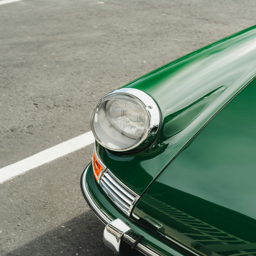

In [9]:
first_img

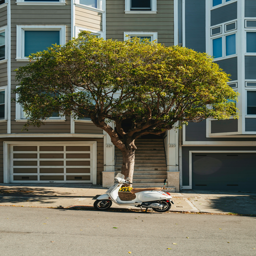

In [10]:
second_img

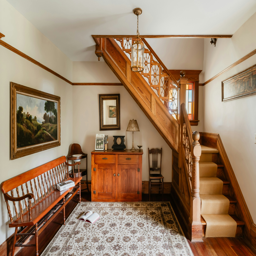

In [11]:
third_img

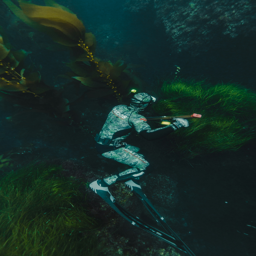

In [22]:
fourth_image

Convolutions have many interesting applications in image processing. For example, you can highlight edges in an image by applying an edge detection kernel, or use specific kernels to produce effects like grayscale or blurring. Below are a few common examples:

__Edge Detection (Sobel Operator)__

The Sobel operator is a well-known method for edge detection. It uses two kernels: one for vertical edges and one for horizontal edges.

$$
\text{Sobel}_x = \begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
$$

$$
\text{Sobel}_y = \begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix}
$$


__Grayscale Conversion__

To approximate a grayscale image, you can apply separate kernels across the Red, Green, and Blue channels, then combine the results:

$$
\text{Grayscale\_R} = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0.3 & 0 \\
0 & 0 & 0
\end{bmatrix}
\quad
\text{Grayscale\_G} = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0.6 & 0 \\
0 & 0 & 0
\end{bmatrix}
\quad
\text{Grayscale\_B} = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0.1 & 0 \\
0 & 0 & 0
\end{bmatrix}
$$

Each kernel is convolved with its corresponding channel before combining them into the grayscale output.


__Blurring (Gaussian Blur)__

Blurring smooths an image by averaging pixel values in a neighborhood. A common choice is the Gaussian Blur kernel:

$$
\text{Gaussian\_Blur} = \frac{1}{16} \times
\begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{bmatrix}
$$


In [12]:
import numpy as np

# Kernels
Sobelx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])

Sobely = np.array([[-1, -2, -1],
                   [0, 0, 0],
                   [1, 2, 1]])

Grayscale_across_R = np.array([[0, 0, 0],
                               [0, 0.3, 0],
                               [0, 0, 0]])

Grayscale_across_G = np.array([[0, 0, 0],
                               [0, 0.6, 0],
                               [0, 0, 0]])

Grayscale_across_B = np.array([[0, 0, 0],
                               [0, 0.1, 0],
                               [0, 0, 0]])

Gaussian_Blur = np.array([[1, 2, 1],
                          [2, 4, 2],
                          [1, 2, 1]]) / 16


In [ ]:
img_size = 256

x = np.stack([
    np.array(first_img).transpose(2, 0, 1),
    np.array(second_img).transpose(2, 0, 1),
    np.array(third_img).transpose(2, 0, 1),
    np.array(fourth_image).transpose(2, 0, 1)
])

w = np.zeros((4, 3, 3, 3))
w[0, 0], w[0, 1], w[0, 2] = Grayscale_across_R, Grayscale_across_G, Grayscale_across_B
w[1] = Sobelx
w[2] = Sobely
w[3] = Gaussian_Blur

b = np.array([0, 128, 128, 0])

conv = MyConv(stride=1, padding=1)
out = conv.forward(x, w, b)
print(out.shape)  # (4, 4, 256, 256)

(4, 4, 256, 256)


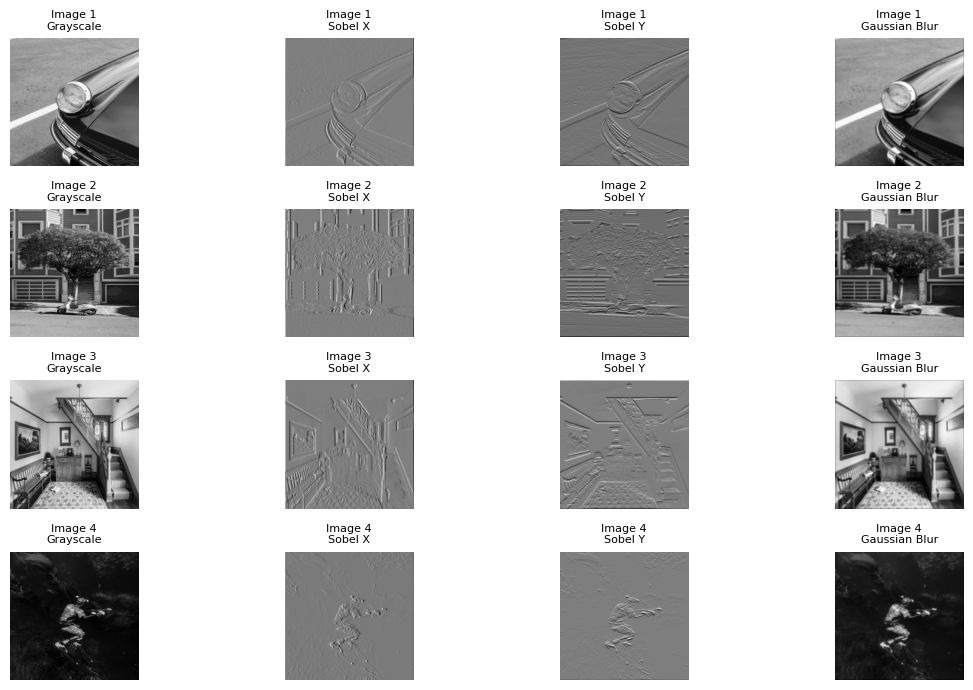

In [24]:
import matplotlib.pyplot as plt

num_images, num_channels, H, W = out.shape
channel_labels = ['Grayscale', 'Sobel X', 'Sobel Y', 'Gaussian Blur']

plt.figure(figsize=(12, 7))

for i in range(num_images):
    for j in range(num_channels):
        idx = i * num_channels + j + 1
        plt.subplot(num_images, num_channels, idx)
        plt.imshow(out[i, j], cmap='gray')
        plt.title(f'Image {i+1}\n{channel_labels[j]}', fontsize=8)
        plt.axis('off')

plt.tight_layout()
plt.show()


In [25]:
np.array(first_img).transpose(2, 0, 1)

array([[[188, 196, 208, ..., 171, 169, 168],
        [231, 233, 236, ..., 173, 170, 169],
        [239, 238, 238, ..., 179, 172, 169],
        ...,
        [120, 123, 124, ...,  21,  15,  12],
        [130, 133, 123, ...,   6,   4,   3],
        [137, 123, 116, ...,  28,  14,   8]],

       [[191, 199, 211, ..., 173, 171, 170],
        [232, 235, 237, ..., 175, 172, 171],
        [240, 239, 239, ..., 178, 174, 171],
        ...,
        [122, 124, 126, ...,  58,  52,  46],
        [132, 130, 124, ...,  42,  41,  40],
        [138, 123, 117, ...,  61,  48,  44]],

       [[179, 189, 201, ..., 160, 158, 157],
        [226, 229, 231, ..., 161, 159, 158],
        [234, 233, 233, ..., 164, 161, 158],
        ...,
        [111, 113, 115, ...,  35,  31,  27],
        [118, 115, 112, ...,  25,  24,  23],
        [124, 108, 105, ...,  40,  31,  26]]], dtype=uint8)